In [13]:
using Revise, Statistics, LaTeXStrings, DSP, StatsBase
using Formatting, MAT, FFTW, Unitful
import Unitful: m, s, Hz, AbstractQuantity
using CairoMakie, Makie
using ColorSchemes
import ColorSchemes: nord, tab10, Dark2_8

printx(x,N) = sprintf1("%.$(N)f",x)
toUnit(unit) = x -> uconvert(unit, x)



# fg = :black; gg = :grey; cscheme = tab10
fg = nord[5]; gg = nord[3]; cscheme = Dark2_8
bg = :transparent


set_theme!(Theme(
    fontsize = 20,
    palette = ( color = cscheme,),
    markerstrokewidth=0.1,
    Axis = (
        backgroundcolor = bg,
        xtickcolor = fg, ytickcolor = fg,
        xgridcolor = gg, ygridcolor = gg,
        xlabelcolor = fg, ylabelcolor = fg,
        xticklabelcolor = fg, yticklabelcolor = fg,
        topspinecolor = fg, bottomspinecolor = fg,
        leftspinecolor = fg, rightspinecolor = fg,
        titlecolor = fg,
    ),
    Legend = (
        bgcolor = bg,
        labelcolor = fg, titlecolor = fg,
        framevisible = false, margin=(0,0,0,0)
    )
))

In [29]:
Makie.convert_single_argument(x::Vector{<: AbstractQuantity}) = ustrip.(x)

In [15]:
matfile = matread("mimo_project.mat")

Dict{String, Any} with 12 entries:
  "N_rx"      => 32.0
  "c"         => 340.0
  "tx_pos"    => [-0.0085 0.0085]
  "B"         => 10000.0
  "cdma_data" => ComplexF64[0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im; 0.0+0.0i…
  "T_p"       => 0.01
  "fs"        => 200000.0
  "rx_pos"    => [-0.527 -0.493 … 0.493 0.527]
  "N_tx"      => 2.0
  "fc"        => 10000.0
  "tdma_data" => [0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im; 0.0+0.0im 0.0+0.0i…
  "N_t"       => 10000.0

In [16]:
Nᵣₓ = matfile["N_rx"] |> Int
Nₜₓ = matfile["N_tx"] |> Int
Nₜ  = matfile["N_t"]  |> Int

c   = matfile["c"] * m/s
B   = matfile["B"] * Hz
fs  = matfile["fs"] * Hz
fc  = matfile["fc"] * Hz
Tₚ  = matfile["T_p"] * s

tₓ_pos = matfile["tx_pos"]
rₓ_pos = matfile["rx_pos"] 

tdma_data = matfile["tdma_data"]
cdma_data = matfile["cdma_data"];

In [19]:
# Create waveforms
α = B/Tₚ
S_up   = (t -> @. exp(1im*2π*((fc - B/2)*t + α*t^2/2)))(0s:1/fs:Tₚ);
S_down = (t -> @. exp(1im*2π*((fc + B/2)*t - α*t^2/2)))(0s:1/fs:Tₚ);

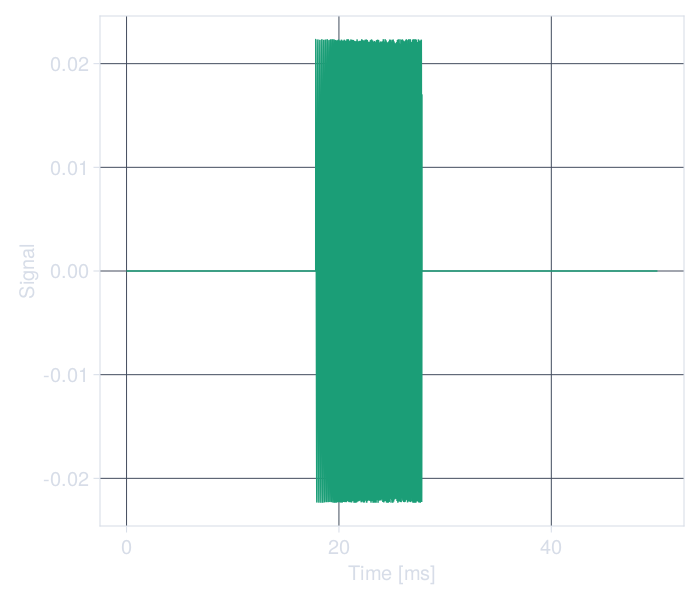

In [32]:
F = Figure(backgroundcolor=bg, resolution=(700,600))
ax = Axis(F[1,1], xlabel="Time [ms]", ylabel="Signal")
lines!(ax, (0:size(tdma_data,1)-1)./fs .|> toUnit(u"ms"), real(tdma_data[:,1,1]))
F

In [33]:
match_filter(x, y) = conv(x, reverse(conj(y)))[length(y)÷2+1:end-(length(y)÷2)]

match_filter (generic function with 1 method)

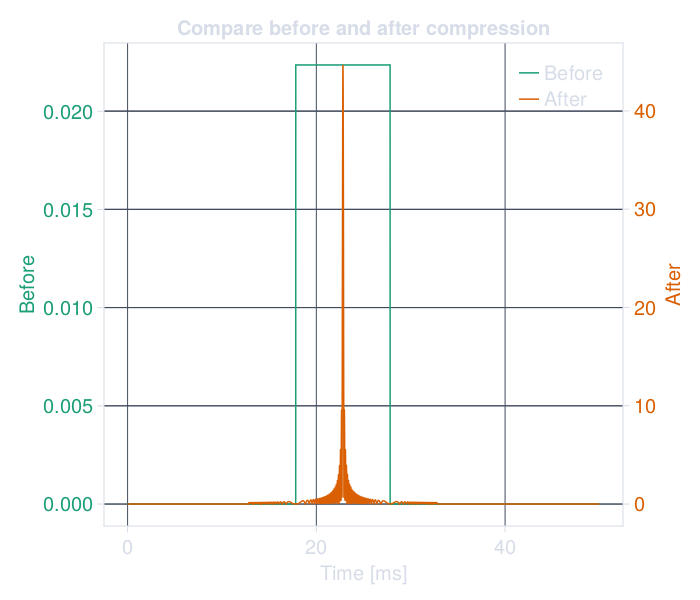

In [45]:
raw_signal = tdma_data[:,1,1]
match_signal = match_filter(raw_signal, S_up)

t = (0:length(raw_signal)-1)./fs .|> toUnit(u"ms")

F = Figure(backgroundcolor=bg, resolution=(700,600))
ax1 = Axis(F[1, 1], yticklabelcolor = cscheme[1], xlabel="Time [ms]", ylabel="Before", ylabelcolor=cscheme[1],
    title="Compare before and after compression")
ax2 = Axis(F[1, 1], yticklabelcolor = cscheme[2], yaxisposition = :right, ylabel="After", ylabelcolor=cscheme[2])
hidespines!(ax2)
hidexdecorations!(ax2)
l1 = lines!(ax1, t, abs.(raw_signal), color=cscheme[1])
l2 = lines!(ax2, t, abs.(match_signal), color=cscheme[2])
axislegend(ax1, [l1, l2], ["Before", "After"])

F

## Theoretical time resolution of pulse compression

In [42]:
δτ = 1/B |> toUnit(u"ms")

0.1 ms